In [1]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq


In [2]:
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
    #    print("Warning: Data size = %g, is not a power of 2." % floor(2**d))
    #    print("Truncating data to %g." % 2**floor(d) )
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in arange(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]

    # we need a list of magic numbers
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))



In [ ]:
def writhe(s1,s2):
    """
    Computes Writhe according to the definition offered by "protein folding by minimization"
    input: each segment is a list of two [x,y,z] coordinate pairs 
    ouptut: writhe number for segment pairs 
    """
    # vectors created directed towards poles of spherical quadrilateral 
    v14 = s1[0]-s2[1]
    v13 = s1[0]-s2[0]
    v24 = s1[1]-s1[1]
    v23 = s1[1]-s2[0]
    norm_a = np.cross(v14,v13)
    norm_b = np.cross(v14,v24)
    norm_c = np.cross(v23, v24)
    norm_d = np.cross(v23,v13)
    
    # compute angles of spherical quadrilaterals 
    # should we clip arccos? 
    A = np.arccos(np.dot(a,d)/(np.linalg.norm(a)*np.linalg.norm(d)))
    B = np.arccos(np.dot(b,a)/(np.linalg.norm(b)*np.linalg.norm(a)))
    C = np.arccos(np.dot(c,b)/(np.linalg.norm(c)*np.linalg.norm(b)))
    D = np.arccos(np.dot(d,c)/(np.linalg.norm(d)*np.linalg.norm(c)))
    
    omega_ij = A + B + C + D - 2*np.pi
    W_ij = 2*omega_ij/ (4*np.pi) # could be without the 2 if computing throughout the whole
    # should we calculate sign of W_ij separately? 
    return W_ij 
    

some pseudo code for writhe_matrix 
CA_ls = coordinates of alpha carbons 

def writhe_matrix(CA_ls):
    arr = np.zeros((res_num,res_num)) # matrix to fill in 
    # even number of residues case 
    if len(CA_ls) % 2 == 0: 
        end = (len(CA_ls)+1)/2
    # odd number of residues case 
    else: 
        end = len(CA_ls)/2 + 1 
    for n in range(end): 
        for m in range(len(CA_ls[n+1,:])-1):
           s1 = (CA_ls[n], CA_ls[n+1])
           s2 = (CA_ls[m], CA_ls[m+1])
           W_ij = writhe(s1,s2) # there's a caveat to computing this 
           arr[n][m] = W_ij
           arr[m][n] = -1*W_ij 
    return arr 

In [3]:
def writhe(segment1,segment2):
    '''Compute writhe contribution from two input [x,y,z] cooridnate pairs'''
    s1 = segment1
    s2 = segment2
    #form unit vectors at the segment extremes:
    v13 = s2[0] - s1[0]
    v23 = s2[0] - s1[1]
    v24 = s2[1] - s1[1]
    v14 = s2[1] - s1[0]
    v = [v13,v23,v24,v14,v13,v23]
    e = []
    l13 = np.linalg.norm(v13)
    l23 = np.linalg.norm(v23)
    l24 = np.linalg.norm(v24)
    l14 = np.linalg.norm(v14)
    ls = [l13,l23,l24,l14]
    for l in ls:
        if l == 0.0:
            return 0
    e13 = v13/l13
    e23 = v23/l23
    e24 = v24/l24
    e14 = v14/l14
    e = [e13,e23,e24,e14,e13,e23]
    #compute the angles
    s = 0
    for i in range(1,len(e)-1):
        a = e[i-1]
        b =e[i]
        c = e[i+1]
        v1=a-b
        v3=c-b
        a=np.dot(v1,v3)/(np.linalg.norm(v1)*np.linalg.norm(v3))
        theta=np.arccos(np.clip(a, -1.0, 1.0))  
        s = s +theta
    w = np.sign(s)*2*np.pi - s
    return w


In [4]:
def writhe_matrix(segment1,segment2):
 v13 = s2[:,0] - s1[:,0]
 v23 = s2[:,0] - s1[:,1]
 v24 = s2[:,1] - s1[:,1]
 v14 = s2[:,1] - s1[:,0]
 v = [v13,v23,v24,v14,v13,v23]
 e = []
 l13 = np.linalg.norm(v13,axis=1)
 l23 = np.linalg.norm(v23,axis=1)
 l24 = np.linalg.norm(v24,axis=1)
 l14 = np.linalg.norm(v14,axis=1)
 ls = [l13,l23,l24,l14]   
 for l in ls:
        if np.sum(l) == 0.0:
            return 0
 e13 = v13/l13[:,None]
 e23 = v23/l23[:,None]
 e24 = v24/l24[:,None]
 e14 = v14/l14[:,None]
 e = [e13,e23,e24,e14,e13,e23] 
    #compute the angles
 s = 0
 for i in range(1,len(e)-1):
        a = np.asarray(e[i-1])
        b = np.asarray(e[i])
        c = np.asarray(e[i+1])
        #a =e[i-1]
        #b =e[i]
        #c = e[i+1]
        v1=a-b
        v3=c-b
        #a=np.dot(v1,v3)
        a=(v1*v3).sum(axis=1)/(np.linalg.norm(v1,axis=1)*np.linalg.norm(v3,axis=1))
        #a=np.dot(v1,v3)/(np.linalg.norm(v1,axis=1)*np.linalg.norm(v3,axis=1))
        theta=np.arccos(np.clip(a, -1.0, 1.0))  
        s = s +theta
 w = np.sign(s)*2*np.pi - s
 return w

In [2]:
#On Discovery pdb:
#/dartfs-hpc/rc/home/k/f0044gk/labhome/DESRES_Trajectories/biorxiv2021-10398286-asyn_cterm_apo_no-water/asyn_Cterm_apo.proteinonly.pdb
#dcd - 1 million frames, probably want to downsample for starters 
#/dartfs-hpc/rc/home/k/f0044gk/labhome/DESRES_Trajectories/biorxiv2021-10398286-asyn_cterm_apo_no-water/asyn_Cterm_apo.all.dcd
# For starters you can try this one, which is downsampled by 100:
#/dartfs-hpc/rc/home/k/f0044gk/labhome/DESRES_Trajectories/biorxiv2021-10398286-asyn_cterm_apo_no-water/asyn_Cterm_apo.proteinonly.s100.dcd

workdir='/Users/paulrobustelli/Asyn_LigandBinding'
trajdir='/Users/paulrobustelli/Desktop/Trajectories/asyn120to140'
pdb='/Users/paulrobustelli/Desktop/Trajectories/asyn120to140/asyn120to140.apo.pdb'
trajectory=trajdir+'/asyn120to140.apo.dcd'

In [7]:
trj = md.load(trajectory,top=pdb,stride=200)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [8]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
prot_top=top.subset(top.select('protein'))
prot_res=[]
for res in prot_top.residues: prot_res.append(res.resSeq)
prot_resname=(' %s' % [residue.name for residue in prot_top.residues])
residues=len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

residues=20
residue_offset=121
residue_number = range(residue_offset, residue_offset+residues)
print("Residue Number Range:",residue_number)


** SYSTEM INFO **

Number of atoms: 294

Number of residues: 20

Number of protein residues: 20

Number of frames: 2778

Starting frame: 0

Last frame: 2778

sequence:  [ASP121, ASN122, GLU123, ALA124, TYR125, GLU126, MET127, PRO128, SER129, GLU130, GLU131, GLY132, TYR133, GLN134, ASP135, TYR136, GLU137, PRO138, GLU139, ALA140]

residue names:  ['ASP', 'ASN', 'GLU', 'ALA', 'TYR', 'GLU', 'MET', 'PRO', 'SER', 'GLU', 'GLU', 'GLY', 'TYR', 'GLN', 'ASP', 'TYR', 'GLU', 'PRO', 'GLU', 'ALA']

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

Residue Number Range: range(121, 141)


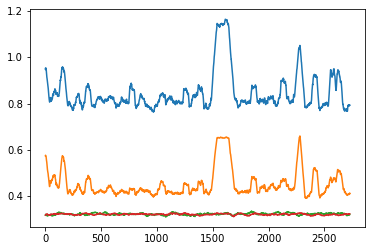

In [9]:
#pdb='/Users/paulrobustelli/Desktop/Trajectories/asyn120to140/asyn120to140.apo.pdb'
ref=md.load_pdb(pdb)
top_ref=ref.topology
sel1=top_ref.select("backbone and residue 125 to 135")
sel2=top_ref.select("backbone and residue 121 to 125")
sel3=top_ref.select("backbone and residue 135 to 140")

rmsd = md.rmsd(trj,ref)
rmsd1= md.rmsd(trj,ref,atom_indices=sel1)
rmsd2= md.rmsd(trj,ref,atom_indices=sel2)
rmsd3= md.rmsd(trj,ref,atom_indices=sel3)

N=50
#plt.plot(rmsd)
plt.plot(np.convolve(rmsd,np.ones(N)/N,mode='valid'))

#plt.plot(rmsd1)
plt.plot(np.convolve(rmsd1,np.ones(N)/N,mode='valid'))
plt.plot(np.convolve(rmsd2,np.ones(N)/N,mode='valid'))
plt.plot(np.convolve(rmsd3,np.ones(N)/N,mode='valid'))



In [10]:
#out="R2R2.writhe"

CAatoms=trj.topology.select('name CA')
CAdihe_index=[]
CAlabel=[]
CAang_index=[]
CAvec_index=[]
CApos=trj.xyz[:,CAatoms]

for i in range(0,len(CAatoms)):
     CAlabel.append(trj.topology.atom(CAatoms[i]).residue.resSeq)

print(np.array(CAlabel).astype(int))
#wr=[]
#Calculate Total Chian Writhe#

#for i in range(0,len(CApos)):
#    w=0
#    for j in range(0,len(CAlabel)-3):
#     v1=CApos[i][j]; v2=CApos[i][j+1];
#     for k in range(j+1,len(CAlabel)-1):
#      v3=CApos[i][k]; v4=CApos[i][k+1];
#      w+=writhe([v1,v2],[v3,v4])
#    wr.append(w)


[121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140]


In [11]:
#Writhe Matrix Operation
#Capos=[CA(x,y,z)xCA] -(2778, 20, 3) for each rom
#Make Vectors of certain spacing for each row 
#np.shape(wr)
#For Debugging
#Frames by CA positions: CApos[:,n], where n is CA of residue i

def get_segments(segment1,segment2):
    '''Compute writhe contribution from two input [x,y,z] cooridnate pairs'''
    s1 = segment1
    #print("s1:",s1)
    s2 = segment2
    #print("s2:",s2)
    #form unit vectors at the segment extremes:
    v13 = s2[0] - s1[0]
    v23 = s2[0] - s1[1]
    v24 = s2[1] - s1[1]
    v14 = s2[1] - s1[0]
    #print("v13:",v13)
    #print("v23:",v23)
    #print("v24:",v24)
    #print("v14:",v14)
    v = [v13,v23,v24,v14,v13,v23]
    e = []
    l13 = np.linalg.norm(v13)
    l23 = np.linalg.norm(v23)
    l24 = np.linalg.norm(v24)
    l14 = np.linalg.norm(v14)
    ls = [l13,l23,l24,l14]
    #print("ls:",ls)
    for l in ls:
        if l == 0.0:
            return 0
    e13 = v13/l13
    e23 = v23/l23
    e24 = v24/l24
    e14 = v14/l14
    e = [e13,e23,e24,e14,e13,e23]    
    #print("e:",np.shape(e),e)
    s = 0
    for i in range(1,len(e)-1):
        a = e[i-1]
        b =e[i]
        c = e[i+1]
        v1=a-b
        v3=c-b
        #print("v1",np.shape(v1),v1)
        #print("v3",np.shape(v3),v3)
        a=np.dot(v1,v3)
        #print("Segment","i",i,"a",np.shape(a),a)
        a=np.dot(v1,v3)/(np.linalg.norm(v1)*np.linalg.norm(v3))
        theta=np.arccos(np.clip(a, -1.0, 1.0))  
        s = s +theta
        #print("s:",s)
    w = np.sign(s)*2*np.pi - s
    print("w:",w)
    return

#get_segments([CApos[0][0],CApos[0][1]],[CApos[0][2],CApos[0][3]])
#get_segments([CApos[1][0],CApos[1][1]],[CApos[1][2],CApos[1][3]])

#Collect CA Positions
#v1=CApos[:,0]
#v2=CApos[:,1]
#v3=CApos[:,2]
#v4=CApos[:,3]


#Put positions in array of dimensions Framesx2x3 - Row=[[x,y,z][x,y,z]]
#s1=np.empty((len(CApos),2,3))
#s2=np.empty((len(CApos),2,3))
#s1[:,0]=v1
#s1[:,1]=v2
#s2[:,0]=v3
#s2[:,1]=v4
#w_all=writhe_matrix(s1,s2)
#print("w_all:",w_all)

In [12]:
wr_total={}
for j in range(0,len(CAlabel)-1):
 wr_total[j]={}
 v1=CApos[:,j]; v2=CApos[:,j+1];
 s1=np.empty((len(CApos),2,3))
 s1[:,0]=v1
 s1[:,1]=v2
 for k in range(j+1,len(CAlabel)-1):
      v3=CApos[:,k]; v4=CApos[:,k+1];
      s2=np.empty((len(CApos),2,3))
      s2[:,0]=v3
      s2[:,1]=v4
      wr_total[j][k]=writhe_matrix(s1,s2)

writhe_by_res={}
wtot=np.zeros(len(CApos[:,0]))
for i in wr_total:
    w=np.zeros(len(CApos[:,0]))
    for j in wr_total[i]:
       w+=wr_total[i][j] 
    writhe_by_res[i]=w
    wtot+=w

In [13]:
#Sum over all pairs - not just the top half of the matrix
wr_total={}
for j in range(0,len(CAlabel)-1):
 wr_total[j]={}
 v1=CApos[:,j]; v2=CApos[:,j+1];
 s1=np.empty((len(CApos),2,3))
 s1[:,0]=v1
 s1[:,1]=v2
 for k in range(0,len(CAlabel)-1):
      v3=CApos[:,k]; v4=CApos[:,k+1];
      s2=np.empty((len(CApos),2,3))
      s2[:,0]=v3
      s2[:,1]=v4
      wr_total[j][k]=writhe_matrix(s1,s2)

writhe_by_res={}
wtot=np.zeros(len(CApos[:,0]))
for i in wr_total:
    w=np.zeros(len(CApos[:,0]))
    for j in wr_total[i]:
       w+=wr_total[i][j] 
    writhe_by_res[i]=w
    wtot+=w

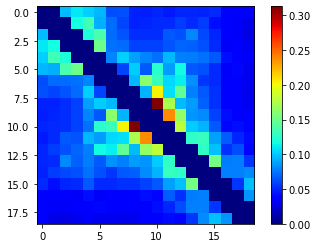

In [14]:
#Visualize Average Writhe Values in NxN Matrix 
writhe_matrx=np.zeros((len(CAlabel)-1,len(CAlabel)-1))
for j in wr_total:
   for k in wr_total[j]:
     writhe_matrx[j,k]=np.average(wr_total[j][k])
        
#print(writhe_matrx)
plt.imshow(writhe_matrx,cmap='jet')
plt.colorbar()

#wr_total[j][k]

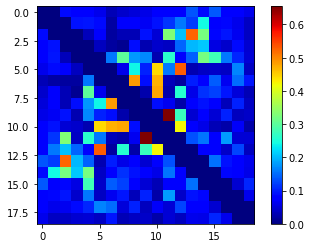

In [15]:
#Visualize Average Writhe Values in Twisted Conformation
writhe_matrx=np.zeros((len(CAlabel)-1,len(CAlabel)-1))
for j in wr_total:
   for k in wr_total[j]:
     a=np.asarray(wr_total[j][k])
     if a.all()!= 0:
      writhe_matrx[j,k]=np.average(a[1540:1700])
        
#print(writhe_matrx)
plt.imshow(writhe_matrx,cmap='jet')
plt.colorbar()
#wr_total[j][k]

In [16]:
w_by_res=[]
for i in writhe_by_res:
    print(i+121,np.average(writhe_by_res[i]))
    w_by_res.append(np.average(writhe_by_res[i]))

121 1.0488069344791584
122 0.9916023556045274
123 1.0758187461203574
124 1.1252124104082195
125 1.2952853349058913
126 1.3224015371127262
127 1.2657757825679425
128 1.2837371988142432
129 1.4025495793890386
130 1.3644823116440892
131 1.6267379052462925
132 1.5477543835146659
133 1.526234321797419
134 1.3267100762966053
135 1.2387189042941134
136 1.0993209312182912
137 0.7789341282395084
138 0.7480835854896123
139 0.7557304660405182


In [17]:
#OLD Non vectorized code, very slow!
#Calctulate writhe contribution for each Cai-Cai+1 segment
#wtot=[]
#writhe_matrix_by_res={}
#for j in range(0,len(CAlabel)-1):
     #writhe_matrix_by_res[CAlabel[j]]={}
#     w=[]
#     for i in range(0,len(CApos)):
#      v1=CApos[i][j]; v2=CApos[i][j+1];
#      wf=[]
#      for k in range(0,len(CAlabel)-1):
#       v3=CApos[i][k]; v4=CApos[i][k+1];
#       wf.append(writhe([v1,v2],[v3,v4]))
#      w.append(wf)
#     writhe_matrix_by_res[CAlabel[j]]=np.asarray(w)     
     #np.savetxt('%s.%s.writhe.dat'%(out,CAlabel[j]),w,'%.4lf')
     #np.savetxt('%s.%s.sum.writhe.dat'%(out,CAlabel[j]),sum(w,axis=1),'%.4lf')
#     wtot.append(np.mean(sum(w,axis=1)))
#     print(CAlabel[j],np.mean(sum(w,axis=1)))
#print(np.asarray(CAlabel).astype(int)[0:-1],np.asarray(wtot))
#outsum=np.column_stack((np.asarray(CAlabel).astype(float)[0:-1],np.asarray(wtot)))
#np.savetxt('%s.sum.writhe.dat'%(out),outsum,'%d %.4lf')


<ipython-input-2-6f4713030d43>:24: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


<ErrorbarContainer object of 3 artists>

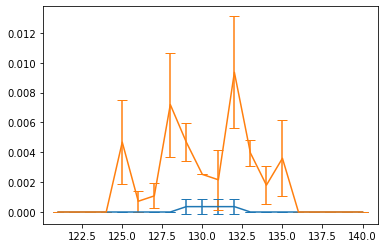

In [18]:
dssp=md.compute_dssp(trj, simplified=True)
#np.savetxt(wdir+"/dssp.out",dssp,fmt='%s')

dsspH=np.copy(dssp)
dsspE=np.copy(dssp)
dsspH[dsspH=='H']=1                                                                                      
dsspH[dsspH=='E']=0                                                                                      
dsspH[dsspH=='C']=0                                                                                      
dsspH[dsspH=='NA']=0 
dsspH=dsspH.astype(int)
TotalH=np.sum(dsspH,axis=1) 
#np.savetxt(wdir+"/dssp.HTOT.dat",TotalH,fmt='%i')

#Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspH)
SE_H=np.zeros((len(prot_res),2))

for i in range(0,len(prot_res)): 
     data=dsspH[:,i].astype(float) 
     if(np.mean(data)>0):
      SE_H[i]=[np.mean(data),(block(data))**.5] 


dsspE[dsspE=='H']=0
dsspE[dsspE=='E']=1
dsspE[dsspE=='C']=0
dsspE[dsspE=='NA']=0
dsspE=dsspE.astype(int)
TotalE=np.sum(dsspE,axis=1) 

Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)
SE_E=np.zeros((len(prot_res),2))

for i in range(0,len(prot_res)):
     data=dsspE[:,i].astype(float)
     if(np.mean(data)>0):
      SE_E[i]=[np.mean(data),(block(data))**.5]
    
plt.errorbar(prot_res,SE_H[:,0],yerr=SE_H[:,1], capsize=5)
plt.errorbar(prot_res,SE_E[:,0],yerr=SE_E[:,1], capsize=5)

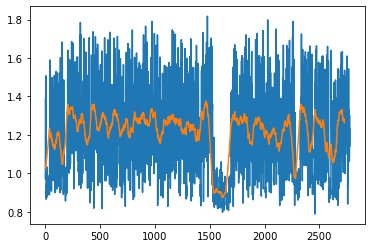

In [19]:
mass=[]
for at in trj.topology.atoms:
    mass.append(at.element.mass)
# calculate mass-weighted radius of gyration on all atoms
rg_all=md.compute_rg(trj, masses=np.array(mass))
plt.plot(rg_all)
N=50
plt.plot(np.convolve(rg_all,np.ones(N)/N,mode='valid'))

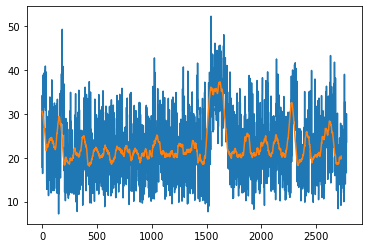

In [20]:
N=50
plt.plot(wtot)
plt.plot(np.convolve(wtot,np.ones(N)/N,mode='valid'))

0.737780957883809
0.7001396879474195


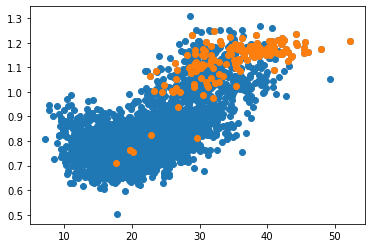

In [21]:
plt.scatter(wtot,rmsd)
plt.scatter(wtot[1540:1700],rmsd[1540:1700])
print(np.corrcoef(wtot,rmsd)[0,1])
print(np.corrcoef(wtot[1540:1700],rmsd[1540:1700])[0,1])




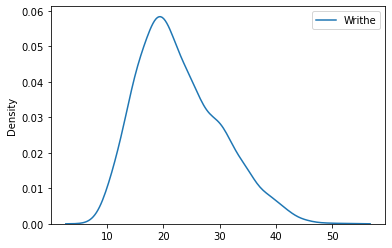

In [22]:
sns.kdeplot(wtot,label='Writhe')
plt.legend(loc='upper right')

Total Writhe vs.  RMSD


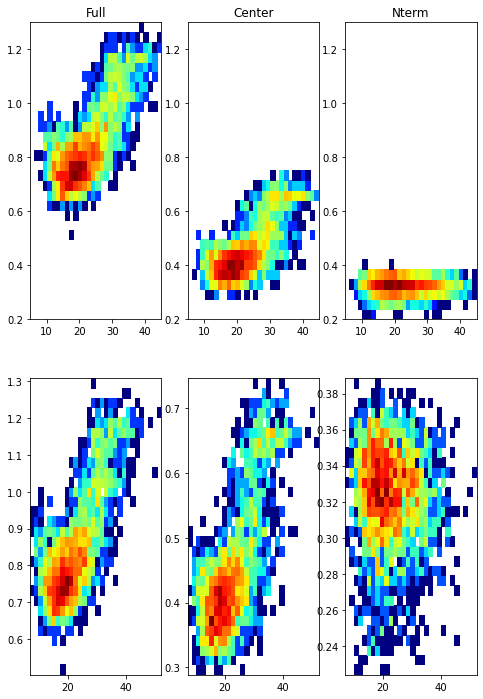

In [23]:
fig, ax = plt.subplots(2,3, figsize=((8,12)))
hist_i=ax[0,0].hist2d(wtot,rmsd,bins=30,norm=colors.LogNorm(),range=[[5,45],[0.2,1.3]],cmap='jet')
hist_i=ax[0,1].hist2d(wtot,rmsd1,bins=30,norm=colors.LogNorm(),range=[[5,45],[0.2,1.3]],cmap='jet')
hist_i=ax[0,2].hist2d(wtot,rmsd2,bins=30,norm=colors.LogNorm(),range=[[5,45],[0.2,1.3]],cmap='jet')
hist_i=ax[1,0].hist2d(wtot,rmsd,bins=30,norm=colors.LogNorm(),cmap='jet')
hist_i=ax[1,1].hist2d(wtot,rmsd1,bins=30,norm=colors.LogNorm(),cmap='jet')
hist_i=ax[1,2].hist2d(wtot,rmsd2,bins=30,norm=colors.LogNorm(),cmap='jet')
ax[0,0].set_title('Full')
ax[0,1].set_title('Center')
ax[0,2].set_title('Nterm')

print("Total Writhe vs.  RMSD")

Rg vs. Total Writhe


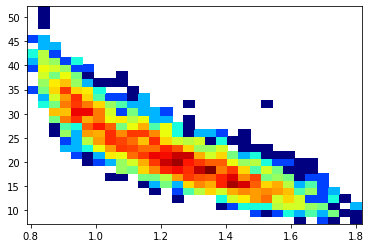

In [288]:
hist=plt.hist2d(rg_all,wtot,bins=30,norm=colors.LogNorm(),cmap='jet')
print("Rg vs. Total Writhe")

Rg vs. RMSD


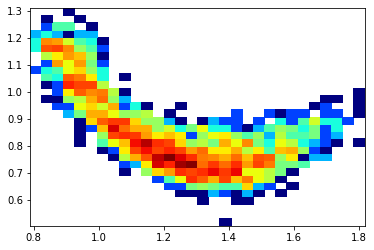

In [289]:
hist=plt.hist2d(rg_all,rmsd,bins=30,norm=colors.LogNorm(),cmap='jet')
print("Rg vs. RMSD")

Writhe vs. RMSD


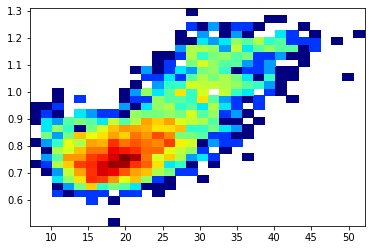

In [290]:
hist=plt.hist2d(wtot,rmsd,bins=30,norm=colors.LogNorm(),cmap='jet')
print("Writhe vs. RMSD")

(2778,) (2778,) (2778,)


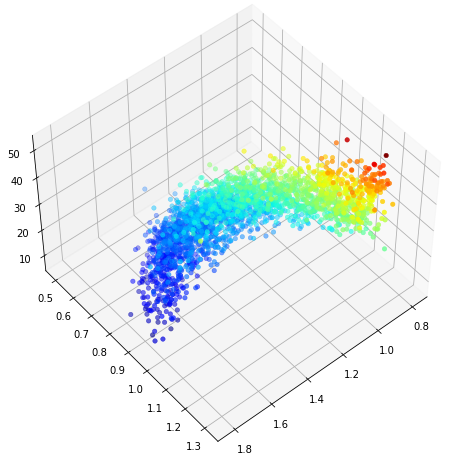

In [291]:
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

print(np.shape(rg_all),np.shape(rmsd),np.shape(wr))
x = rg_all
y = rmsd
z = wtot

xyz = np.vstack([x,y,z])
density = stats.gaussian_kde(xyz)(xyz) 

#print(density)
#idx = density.argsort()
#x, y, z, density = x[idx], y[idx], z[idx], density[idx]

fig = plt.figure(figsize=((8,8)))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=z, cmap='jet', linewidth=0.5);

#ax.scatter(x, y, z, c=density)
#ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis', edgecolor='none');
#ax.plot_trisurf(x, y, z,cmap='viridis', edgecolor='none');
#ax.scatter(x, y, z, c=density)

ax.view_init(elev=50, azim=50)
ax.dist=10

plt.show()


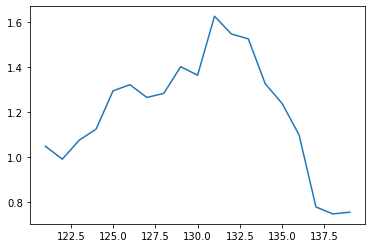

In [292]:
plt.plot(CAlabel[0:-1],w_by_res)

In [270]:
np.shape(writhe_matrix_by_res[121])

(2778, 19)

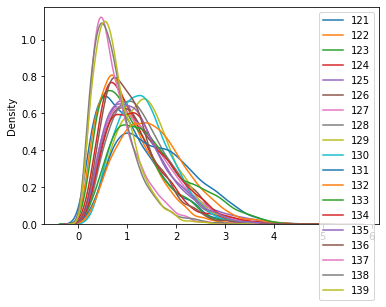

In [271]:
for i in writhe_by_res:
 sns.kdeplot(writhe_by_res[i],label=i+121)
plt.legend(loc='upper right')
plt.show()

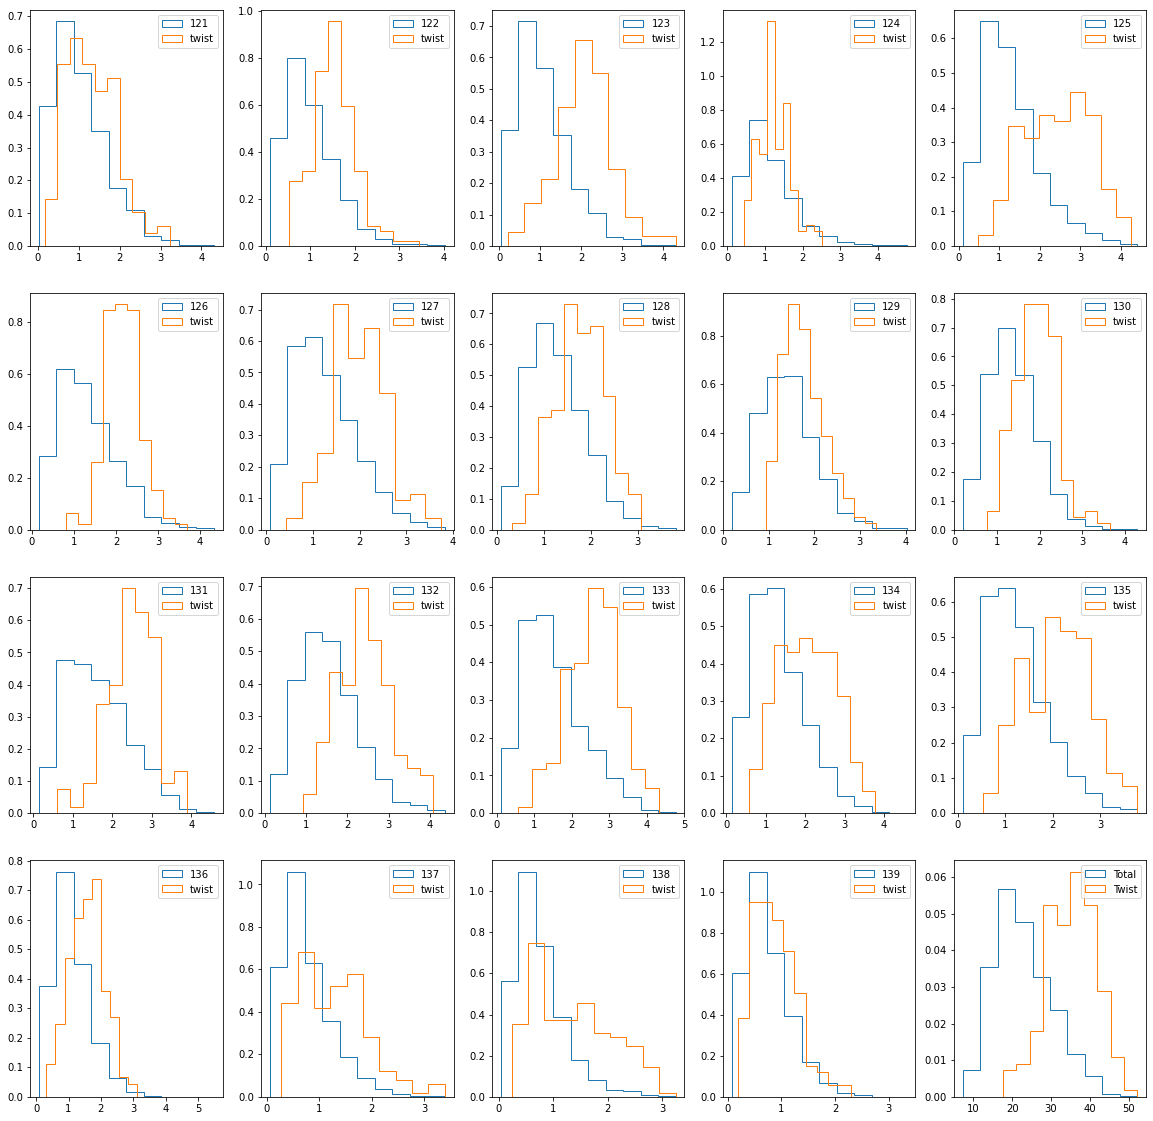

In [272]:
fig, ax = plt.subplots(4,5,figsize=((20,20)))
for i in range(0,4):
 for j in range(0,5):
  k=i*5+j
  #print(i,j,k)
  if(k<19):  
   hist=ax[i,j].hist(writhe_by_res[k],density='true',label=k+121,histtype='step')
   hist=ax[i,j].hist(writhe_by_res[k][1540:1700],density='true',label='twist',histtype='step')
   ax[i,j].legend(loc='upper right')

hist=ax[3,4].hist(wtot,label='Total',density='true',histtype='step')
hist=ax[3,4].hist(wtot[1540:1700],label='Twist',density='true',histtype='step')
ax[3,4].legend(loc='upper right')

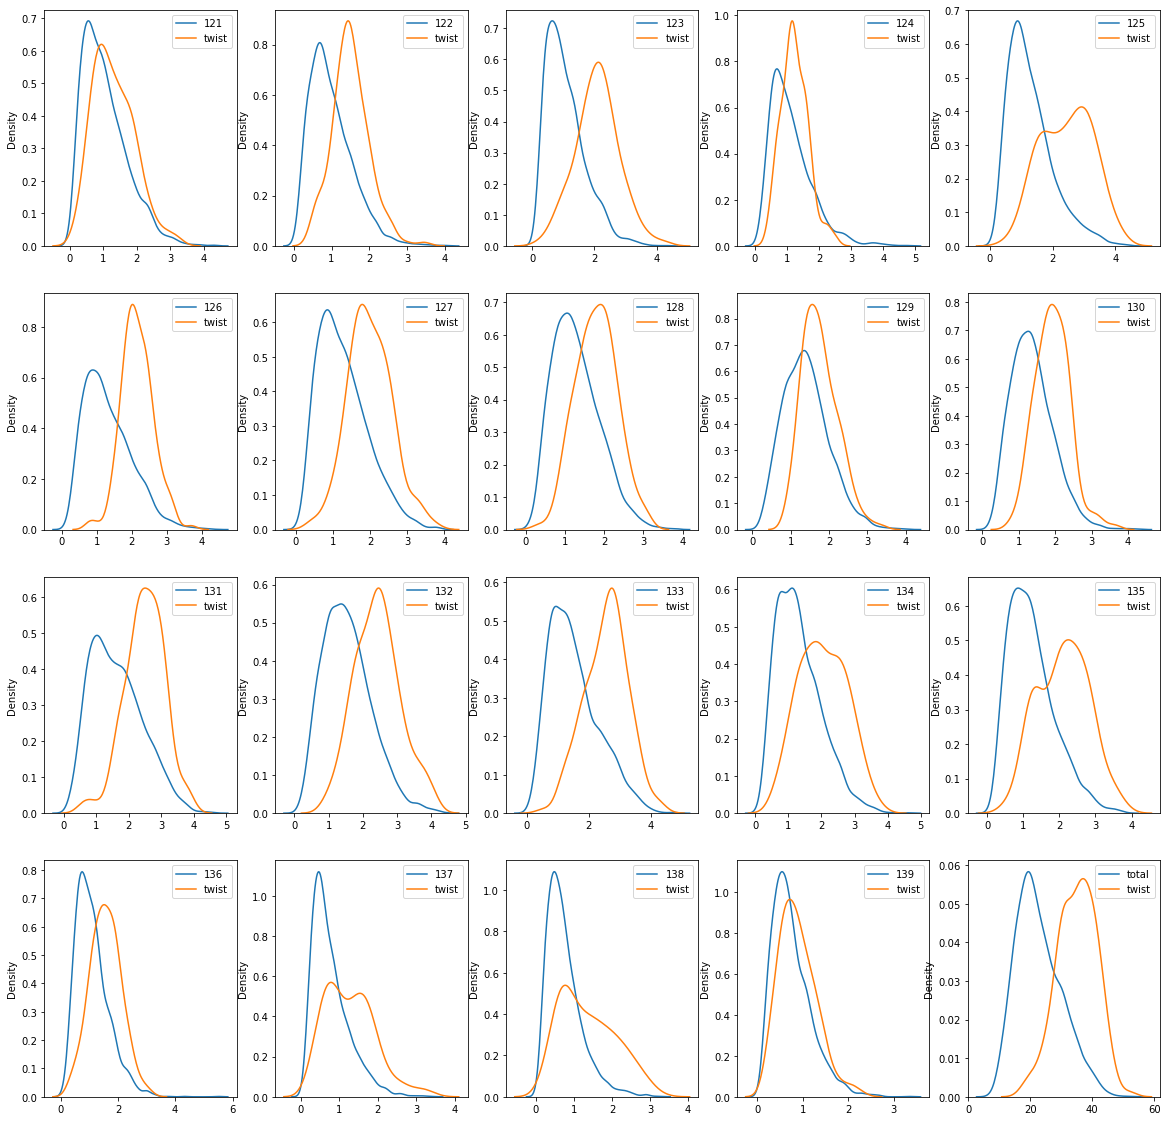

In [273]:
fig, ax = plt.subplots(4,5,figsize=((20,20)))
for i in range(0,4):
 for j in range(0,5):
  k=i*5+j
  if(k<19):  
  #print(i,j,k)
   sns.kdeplot(writhe_by_res[k],label=k+121, ax=ax[i,j])  
   sns.kdeplot(writhe_by_res[k][1540:1700],label='twist', ax=ax[i,j])  
  #hist=ax[i,j].hist(np.sum(writhe_matrix_by_res[k],axis=1),density='true',label=k,histtype='step')
   ax[i,j].legend(loc='upper right')

sns.kdeplot(wtot,ax=ax[3,4],label='total')  
sns.kdeplot(wtot[1540:1700],label='twist', ax=ax[3,4])
ax[3,4].legend(loc='upper right')

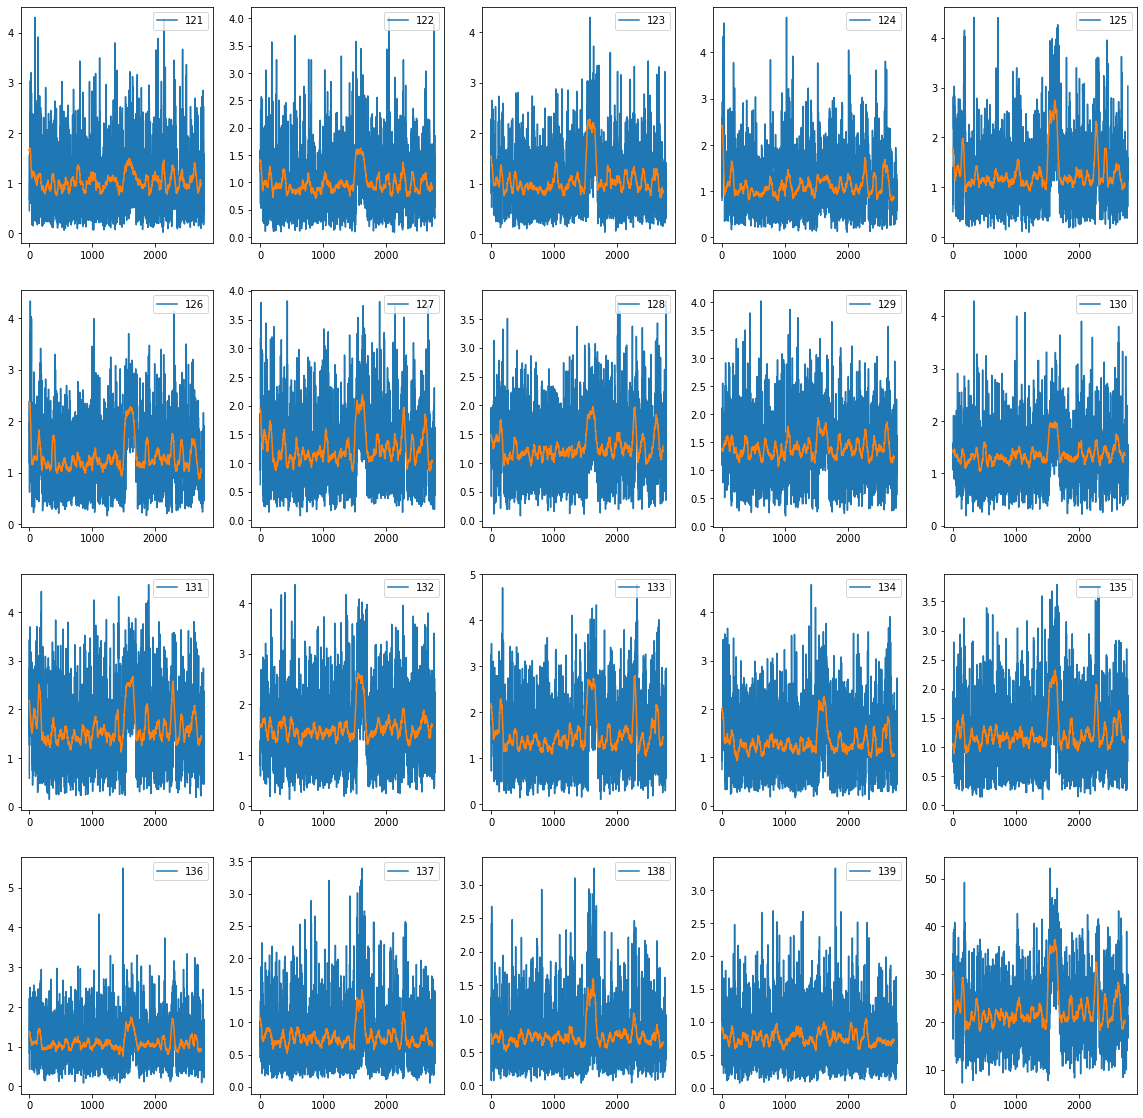

In [274]:
fig, ax = plt.subplots(4,5,figsize=((20,20)))

#Convulution Window
N=50

for i in range(0,4):
 for j in range(0,5):
  k=i*5+j
  if(k<19):  
   hist=ax[i,j].plot(writhe_by_res[k],label=k+121)
   hist=ax[i,j].plot(np.convolve(writhe_by_res[k],np.ones(N)/N,mode='valid'))
   #hist=ax[i,j].sns.kdeplot(np.sum(writhe_matrix_by_res[k],axis=1),label=k)
   ax[i,j].legend(loc='upper right')

hist=ax[3,4].plot(wtot,label='Total')
hist=ax[3,4].plot(np.convolve(wtot,np.ones(N)/N,mode='valid'))


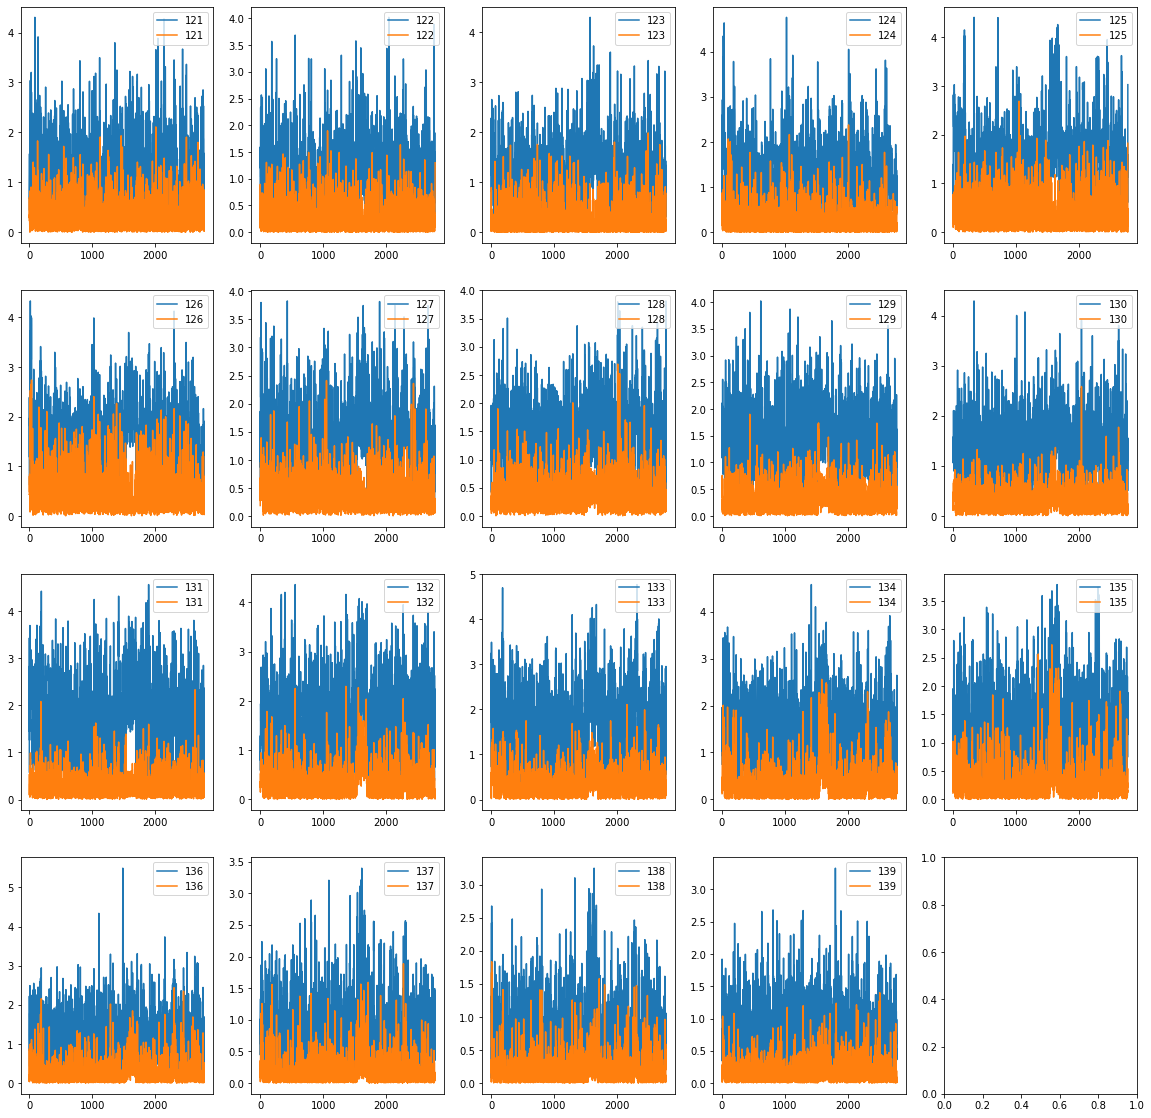

In [275]:
fig, ax = plt.subplots(4,5,figsize=((20,20)))
for i in range(0,4):
 for j in range(0,5):
  k=i*5+j+121
  if(k<140):  
   a=np.asarray(writhe_matrix_by_res[k])     
   hist=ax[i,j].plot(np.sum(a,axis=1),label=k)
   hist=ax[i,j].plot(np.sum(a[:,0:5],axis=1),label=k)
   #hist=ax[i,j].sns.kdeplot(np.sum(writhe_matrix_by_res[k],axis=1),label=k)
   ax[i,j].legend(loc='upper right')


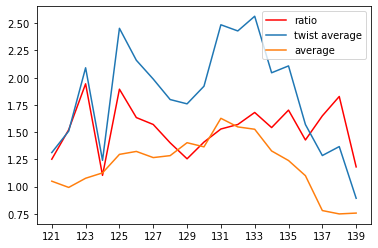

In [276]:
#fig, ax = plt.subplots(4,5,figsize=((20,20)))
#np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
ave=[]
avetwist=[]
ratio=[]
for i in range(0,4):
 for j in range(0,5):
  k=i*5+j
  if(k<19):  
   a=writhe_by_res[k]
   average=np.average(a)
   average_twist=np.average(a[1540:1700])
   ave.append(average)
   avetwist.append(average_twist)
   ratio.append(average_twist/average)
   #print(k,average_twist/average,average_twist,average)
#print(ave_twist/ave)
#plt.plot(ave_twist/ave)
plt.plot(prot_res[0:-1],ratio,color='r',label='ratio')
plt.plot(prot_res[0:-1],avetwist,label='twist average')
plt.plot(prot_res[0:-1],ave,label='average')
plt.legend(loc='upper right')
ticks=plt.xticks(np.arange(121, 140, 2))
